In [3]:
import argparse
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from collections import deque
from scipy.optimize import linear_sum_assignment

In [4]:

def segment_image(image, grid_size):
    """Segments the image into grid_size x grid_size pieces."""
    if isinstance(image, Image.Image):
        image = np.array(image)
    h, w = image.shape[:2]
    piece_h, piece_w = h // grid_size, w // grid_size
    pieces = []
    for i in range(grid_size):
        for j in range(grid_size):
            pieces.append(image[i*piece_h:(i+1)*piece_h, j*piece_w:(j+1)*piece_w])
    return pieces

In [5]:

def compute_nssd(edge1, edge2):
    """
    Compute Normalized Sum of Squared Differences between two edges.
    NSSD = SSD / (std1 * std2) to handle varying intensities.
    
    For uniform edges (std ~ 0), returns SSD directly as NSSD doesn't help.
    """
    ssd = np.sum((edge1.astype(float) - edge2.astype(float)) ** 2)
    std1 = np.std(edge1)
    std2 = np.std(edge2)
    
    # If either edge is uniform, NSSD doesn't work 
    if std1 < 1.0 or std2 < 1.0:
        return ssd / edge1.size  
    
    return ssd / (std1 * std2 * edge1.size)

In [6]:
def compute_dissimilarity_matrices(pieces, use_gradient=True):
    """
    Compute dissimilarity matrices for all piece pairs.
    Uses LAB color space + gradient + NSSD for robust matching.
    
    Returns:
        h_dis: h_dis[i,j] = cost of placing piece j to the RIGHT of piece i
        v_dis: v_dis[i,j] = cost of placing piece j BELOW piece i
    """
    n = len(pieces)
    h_dis = np.zeros((n, n))
    v_dis = np.zeros((n, n))

    pieces_lab = []
    pieces_gray = []
    pieces_grad_x = []
    pieces_grad_y = []
    
    for p in pieces:
        if len(p.shape) == 2:
            p = cv2.cvtColor(p, cv2.COLOR_GRAY2RGB)
        lab = cv2.cvtColor(p, cv2.COLOR_RGB2LAB).astype(np.float64)
        gray = cv2.cvtColor(p, cv2.COLOR_RGB2GRAY).astype(np.float64)
        
        pieces_lab.append(lab)
        pieces_gray.append(gray)
        
        if use_gradient:
            grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
            pieces_grad_x.append(grad_x)
            pieces_grad_y.append(grad_y)
    
    for i in range(n):
        for j in range(n):
            if i == j:
                h_dis[i, j] = np.inf
                v_dis[i, j] = np.inf
                continue
    
            # Match right edge of i with left edge of j
            right_edge = pieces_lab[i][:, -1, :]  
            left_edge = pieces_lab[j][:, 0, :]    
            diff = right_edge - left_edge
            lab_cost = np.mean(np.sqrt(np.sum(diff ** 2, axis=1)))
            
            # Add NSSD component
            nssd = compute_nssd(pieces_gray[i][:, -1], pieces_gray[j][:, 0])
            h_dis[i, j] = lab_cost + 0.05 * nssd
            
            if use_gradient:
                # Add gradient continuity cost
                grad_cost = np.mean(np.abs(pieces_grad_x[i][:, -1] - pieces_grad_x[j][:, 0]))
                h_dis[i, j] += 0.1 * grad_cost
     
            bottom_edge = pieces_lab[i][-1, :, :]  
            top_edge = pieces_lab[j][0, :, :]      
            diff = bottom_edge - top_edge
            lab_cost = np.mean(np.sqrt(np.sum(diff ** 2, axis=1)))
            
            
            nssd = compute_nssd(pieces_gray[i][-1, :], pieces_gray[j][0, :])
            v_dis[i, j] = lab_cost + 0.05 * nssd
            
            if use_gradient:
                grad_cost = np.mean(np.abs(pieces_grad_y[i][-1, :] - pieces_grad_y[j][0, :]))
                v_dis[i, j] += 0.1 * grad_cost
    
    return h_dis, v_dis


In [7]:
def compute_edge_variance(pieces):
    """
    Compute edge variance for each piece.
    Low variance on an edge suggests it was at the image border.
    
    Returns dict: piece_idx -> {'L': left_var, 'R': right_var, 'T': top_var, 'B': bottom_var}
    """
    variances = {}
    for i, p in enumerate(pieces):
        img = np.array(p)
        variances[i] = {
            'L': np.var(img[:, 0, :]),    
            'R': np.var(img[:, -1, :]),   
            'T': np.var(img[0, :, :]),    
            'B': np.var(img[-1, :, :]),  
        }
    return variances


def compute_corner_score(arr, variances, grid_size):
    """
    Compute corner score for an arrangement.
    The correct arrangement should have:
    - TL piece with low L+T variance (top-left border)
    - TR piece with low R+T variance (top-right border)
    - BL piece with low L+B variance (bottom-left border)
    - BR piece with low R+B variance (bottom-right border)
    
    Lower total score = more likely correct arrangement.
    """
    tl = arr[0, 0]
    tr = arr[0, grid_size-1]
    bl = arr[grid_size-1, 0]
    br = arr[grid_size-1, grid_size-1]
    
    score = 0
    if tl >= 0:
        score += variances[tl]['L'] + variances[tl]['T']
    if tr >= 0:
        score += variances[tr]['R'] + variances[tr]['T']
    if bl >= 0:
        score += variances[bl]['L'] + variances[bl]['B']
    if br >= 0:
        score += variances[br]['R'] + variances[br]['B']
    
    return score


def compute_border_score(arr, variances, grid_size):
    """
    Compute score based on edge variance at all border positions.
    For correct arrangement:
    - Left column pieces should have low L variance (were at image left border)
    - Right column pieces should have low R variance (were at image right border)
    - Top row pieces should have low T variance (were at image top border)
    - Bottom row pieces should have low B variance (were at image bottom border)
    
    Lower score = more likely correct arrangement.
    """
    score = 0
    
  
    for c in range(grid_size):
        p = arr[0, c]
        if p >= 0:
            score += variances[p]['T']
    

    for c in range(grid_size):
        p = arr[grid_size-1, c]
        if p >= 0:
            score += variances[p]['B']
    

    for r in range(grid_size):
        p = arr[r, 0]
        if p >= 0:
            score += variances[p]['L']
    
 
    for r in range(grid_size):
        p = arr[r, grid_size-1]
        if p >= 0:
            score += variances[p]['R']
    
    return score



In [8]:
def compute_solution_cost(arr, h_dis, v_dis):
    """Compute total boundary cost of a solution."""
    grid_size = arr.shape[0]
    cost = 0
    
   
    for r in range(grid_size):
        for c in range(grid_size - 1):
            if arr[r, c] >= 0 and arr[r, c+1] >= 0:
                cost += h_dis[arr[r, c], arr[r, c+1]]
    
   
    for r in range(grid_size - 1):
        for c in range(grid_size):
            if arr[r, c] >= 0 and arr[r+1, c] >= 0:
                cost += v_dis[arr[r, c], arr[r+1, c]]
    
    return cost


In [9]:
def find_best_buddies(h_dis, v_dis):
    """
    Find Best Buddies - pairs of pieces that mutually prefer each other.
    
    If piece A's best right neighbor is B, and B's best left neighbor is A,
    then (A, B) is a horizontal best buddy pair.
    
    Returns:
        h_buddies: set of (i, j) where i is left of j (mutual)
        v_buddies: set of (i, j) where i is above j (mutual)
    """
    n = h_dis.shape[0]
    
    # Best right neighbor for each piece - min over columns
    best_right = np.argmin(h_dis, axis=1)
    # Best left neighbor for each piece - min over rows  
    best_left = np.argmin(h_dis, axis=0)
    # Best below neighbor for each piece
    best_below = np.argmin(v_dis, axis=1)
    # Best above neighbor for each piece
    best_above = np.argmin(v_dis, axis=0)
    
    # Find mutual matches
    h_buddies = set()
    for i in range(n):
        j = best_right[i]  
        if best_left[j] == i: 
            h_buddies.add((i, j))
    
    v_buddies = set()
    for i in range(n):
        j = best_below[i]  
        if best_above[j] == i:  
            v_buddies.add((i, j))
    
    return h_buddies, v_buddies


def build_buddy_graph(n, h_buddies, v_buddies):
    """Build a graph of pieces connected by buddy relationships."""
    graph = {i: [] for i in range(n)}
    
    for i, j in h_buddies:
        graph[i].append(('R', j)) 
        graph[j].append(('L', i))  
    
    for i, j in v_buddies:
        graph[i].append(('D', j)) 
        graph[j].append(('U', i))  

    return graph


In [10]:
def bfs_build_puzzle(graph, start_piece):
    """
    Use BFS to place pieces based on buddy constraints.
    
    Returns:
        positions: dict mapping piece_id -> (row, col) in relative coords
    """
    positions = {start_piece: (0, 0)}
    queue = deque([start_piece])
    
    direction_offsets = {
        'R': (0, 1),   # right -> same row, col + 1
        'L': (0, -1),  # left -> same row, col - 1
        'D': (1, 0),   # down -> row + 1, same col
        'U': (-1, 0),  # up -> row - 1, same col
    }
    
    while queue:
        piece = queue.popleft()
        r, c = positions[piece]
        
        for direction, neighbor in graph[piece]:
            if neighbor in positions:
               
                expected = (r + direction_offsets[direction][0],
                           c + direction_offsets[direction][1])
                actual = positions[neighbor]
                if expected != actual:
                    # skip this edge
                    continue
                continue
            
            dr, dc = direction_offsets[direction]
            positions[neighbor] = (r + dr, c + dc)
            queue.append(neighbor)
    
    return positions


def normalize_positions(positions, grid_size):
    """
    Normalize positions to fit in a grid_size x grid_size grid starting at (0,0).
    
    Returns:
        arr: numpy array of shape (grid_size, grid_size) with piece indices
             -1 means empty
        success: True if all positions fit in the grid
    """
    if not positions:
        return None, False
    
    min_r = min(r for r, c in positions.values())
    min_c = min(c for r, c in positions.values())
    
    normalized = {p: (r - min_r, c - min_c) for p, (r, c) in positions.items()}
    
    # Check bounds
    max_r = max(r for r, c in normalized.values())
    max_c = max(c for r, c in normalized.values())
    
    if max_r >= grid_size or max_c >= grid_size:
        return None, False
    
    arr = np.full((grid_size, grid_size), -1, dtype=int)
    for p, (r, c) in normalized.items():
        if 0 <= r < grid_size and 0 <= c < grid_size:
            if arr[r, c] != -1:
                # Collision - two pieces at same position
                return None, False
            arr[r, c] = p
    
    return arr, True


In [11]:

def solve_exhaustive_2x2(pieces):
    """
    For 2x2 puzzles, try all 24 permutations with enhanced scoring.
    Uses boundary cost + corner score + voting ensemble.
    
    Strategy: Try multiple ranking strategies and use voting.
    """
    from itertools import permutations
    from collections import Counter
    
    h_dis, v_dis = compute_dissimilarity_matrices(pieces, use_gradient=True)
    variances = compute_edge_variance(pieces)
    
    # Score each permutation with multiple metrics
    all_perms = list(permutations(range(4)))
    scores = []
    
    for perm in all_perms:
        arr = np.array([[perm[0], perm[1]],
                        [perm[2], perm[3]]], dtype=int)
        
        boundary_cost = compute_solution_cost(arr, h_dis, v_dis)
        corner_score = compute_corner_score(arr, variances, 2)
        border_score = compute_border_score(arr, variances, 2)
        
        scores.append({
            'perm': perm,
            'method':"exhaustive",
            'cost': boundary_cost,
            'arr': arr.copy(),
            'boundary': boundary_cost,
            'corner': corner_score,
            'border': border_score,
        })
    
    
    votes = Counter()
    
    by_boundary = sorted(scores, key=lambda x: x['boundary'])
    votes[by_boundary[0]['perm']] += 5  
    if len(by_boundary) > 1:
        votes[by_boundary[1]['perm']] += 2  
    if len(by_boundary) > 2:
        votes[by_boundary[2]['perm']] += 1  

    by_border = sorted(scores, key=lambda x: x['border'])
    votes[by_border[0]['perm']] += 3  # Weight 3
    
    #boundary + border 
    by_combo1 = sorted(scores, key=lambda x: x['boundary'] + 0.002 * x['border'])
    votes[by_combo1[0]['perm']] += 2

    by_combo2 = sorted(scores, key=lambda x: x['boundary'] + 0.005 * x['border'])
    votes[by_combo2[0]['perm']] += 2
    
    # Pure corner score
    by_corner = sorted(scores, key=lambda x: x['corner'])
    votes[by_corner[0]['perm']] += 1
    

    best_perm = votes.most_common(1)[0][0]
    best_arr = np.array([[best_perm[0], best_perm[1]],
                        [best_perm[2], best_perm[3]]], dtype=int)
    
   
    best_score = None
    for s in scores:
        if s['perm'] == best_perm:
            best_score = s['boundary']
            break
    
    return {
        'arr': best_arr,
        'cost': best_score,
        'start': -1,
        'placed_by_buddies': 0,
        'h_buddies': 0,
        'v_buddies': 0,
    }


In [12]:

def solve_8x8_region_growing(pieces):
    """
    A*-inspired region-growing solver for 8x8 puzzles.
    
    - Best Buddy seeding (start from strongest mutual matches)
    - A*-like selection: f(n) = g(n) + h(n)
    - Ambiguity filtering to avoid uncertain placements
    - Toroidal shift expansion for absolute position
    """
    grid_size = 8
    n = 64
    
    h_dis, v_dis = compute_dissimilarity_matrices(pieces, use_gradient=True)
    h_buddies, v_buddies = find_best_buddies(h_dis, v_dis)
    variances = compute_edge_variance(pieces)
    
    # Build buddy sets for O(1) lookup
    h_buddy_set = {(b[0], b[1]) for b in h_buddies}
    v_buddy_set = {(b[0], b[1]) for b in v_buddies}
    
    all_solutions = []
    seen_keys = set()
    
    def add_solution(arr, method):
        if (arr < 0).any():
            return
        key = tuple(arr.flatten())
        if key not in seen_keys:
            seen_keys.add(key)
            cost = compute_solution_cost(arr, h_dis, v_dis)
            border = compute_border_score(arr, variances, grid_size)
            all_solutions.append({
                'arr': arr.copy(),
                'cost': cost,
                'border': border,
                'method': method,
            })
    
    def get_empty_neighbors(grid, placed_set):
        """Get frontier cells adjacent to placed pieces."""
        neighbors = set()
        for (r, c) in placed_set:
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nr, nc = r + dr, c + dc
                if 0 <= nr < grid_size and 0 <= nc < grid_size and grid[nr, nc] == -1:
                    neighbors.add((nr, nc))
        return neighbors
    
    def astar_grow(seed_piece, seed_pos):
        """
        A*-inspired growth: always pick the LEAST AMBIGUOUS placement.
        
        Key insight from message.txt: prioritize placements where
        best_cost / second_best_cost is low (confident choice).
        """
        grid = np.full((grid_size, grid_size), -1, dtype=int)
        remaining = set(range(n)) - {seed_piece}
        grid[seed_pos] = seed_piece
        placed = {seed_pos}
        
        while remaining:
            frontier = get_empty_neighbors(grid, placed)
            if not frontier:
                break
            
            # Evaluate ALL (slot, piece) candidates
            candidates = []
            
            for (r, c) in frontier:
                slot_candidates = []
                
                for p in remaining:
                    cost = 0
                    count = 0
                    is_buddy = False
                    
                    # Sum costs to all neighbors
                    if c > 0 and grid[r, c-1] >= 0:
                        left = grid[r, c-1]
                        cost += h_dis[left, p]
                        count += 1
                        if (left, p) in h_buddy_set:
                            is_buddy = True
                    if c < 7 and grid[r, c+1] >= 0:
                        right = grid[r, c+1]
                        cost += h_dis[p, right]
                        count += 1
                    if r > 0 and grid[r-1, c] >= 0:
                        top = grid[r-1, c]
                        cost += v_dis[top, p]
                        count += 1
                        if (top, p) in v_buddy_set:
                            is_buddy = True
                    if r < 7 and grid[r+1, c] >= 0:
                        bottom = grid[r+1, c]
                        cost += v_dis[p, bottom]
                        count += 1
                    
                    if count > 0:
                        avg_cost = cost / count
                        slot_candidates.append((avg_cost, p, is_buddy))
                
                if len(slot_candidates) >= 2:
                    slot_candidates.sort()
                    best_cost, best_p, is_buddy = slot_candidates[0]
                    second_cost = slot_candidates[1][0]
                    
                    # Ambiguity ratio (lower = more confident)
                    ambiguity = best_cost / second_cost if second_cost > 0 else 0
                    
                    candidates.append({
                        'pos': (r, c),
                        'piece': best_p,
                        'cost': best_cost,
                        'ambiguity': ambiguity,
                        'is_buddy': is_buddy,
                        'neighbors': count,
                    })
                elif slot_candidates:
                    best_cost, best_p, is_buddy = slot_candidates[0]
                    candidates.append({
                        'pos': (r, c),
                        'piece': best_p,
                        'cost': best_cost,
                        'ambiguity': 0,  # Only one option = certain
                        'is_buddy': is_buddy,
                        'neighbors': count,
                    })
            
            if not candidates:
                break
            
            # A* prioritize buddies, then low ambiguity, then low cost
            # Buddies are 90%+ reliable, so always prefer them
            candidates.sort(key=lambda x: (
                not x['is_buddy'],  
                x['ambiguity'],     
                x['cost']         
            ))
            
            best = candidates[0]
            r, c = best['pos']
            grid[r, c] = best['piece']
            remaining.remove(best['piece'])
            placed.add((r, c))
        
        return grid
    
    def rowwise_greedy(start_piece):
        """Fast row-by-row greedy with buddy bonus."""
        arr = np.full((grid_size, grid_size), -1, dtype=int)
        used = {start_piece}
        arr[0, 0] = start_piece
        
        for r in range(grid_size):
            for c in range(grid_size):
                if arr[r, c] != -1:
                    continue
                
                best_p, best_c = None, np.inf
                for p in range(n):
                    if p in used:
                        continue
                    cost = 0
                    buddy = 0
                    
                    if c > 0:
                        left = arr[r, c-1]
                        cost += h_dis[left, p]
                        if (left, p) in h_buddy_set:
                            buddy += 1
                    if r > 0:
                        top = arr[r-1, c]
                        cost += v_dis[top, p]
                        if (top, p) in v_buddy_set:
                            buddy += 1
                    
                    adj = cost / (1 + buddy * 0.5)
                    if adj < best_c:
                        best_c, best_p = adj, p
                
                if best_p is not None:
                    arr[r, c] = best_p
                    used.add(best_p)
        
        return arr
    
    #A* grow from STRONGEST buddy pairs (best starting point)
    buddy_pairs = []
    for i, j in h_buddy_set:
        buddy_pairs.append((h_dis[i, j], i, j, 'h'))
    for i, j in v_buddy_set:
        buddy_pairs.append((v_dis[i, j], i, j, 'v'))
    buddy_pairs.sort() 
    
    for cost, p1, p2, direction in buddy_pairs[:10]:  
        grid = np.full((grid_size, grid_size), -1, dtype=int)
        remaining = set(range(n)) - {p1, p2}
        
        if direction == 'h':
            grid[3, 3], grid[3, 4] = p1, p2
            placed = {(3, 3), (3, 4)}
        else:
            grid[3, 3], grid[4, 3] = p1, p2
            placed = {(3, 3), (4, 3)}
        
        # Continue with A* logic
        while remaining:
            frontier = get_empty_neighbors(grid, placed)
            if not frontier:
                break
            
            candidates = []
            for (r, c) in frontier:
                slot_cands = []
                for p in remaining:
                    cost_sum = 0
                    cnt = 0
                    is_bud = False
                    
                    if c > 0 and grid[r, c-1] >= 0:
                        cost_sum += h_dis[grid[r, c-1], p]
                        cnt += 1
                        if (grid[r, c-1], p) in h_buddy_set:
                            is_bud = True
                    if c < 7 and grid[r, c+1] >= 0:
                        cost_sum += h_dis[p, grid[r, c+1]]
                        cnt += 1
                    if r > 0 and grid[r-1, c] >= 0:
                        cost_sum += v_dis[grid[r-1, c], p]
                        cnt += 1
                        if (grid[r-1, c], p) in v_buddy_set:
                            is_bud = True
                    if r < 7 and grid[r+1, c] >= 0:
                        cost_sum += v_dis[p, grid[r+1, c]]
                        cnt += 1
                    
                    if cnt > 0:
                        slot_cands.append((cost_sum / cnt, p, is_bud))
                
                if len(slot_cands) >= 2:
                    slot_cands.sort()
                    amb = slot_cands[0][0] / slot_cands[1][0] if slot_cands[1][0] > 0 else 0
                    candidates.append((not slot_cands[0][2], amb, slot_cands[0][0], (r, c), slot_cands[0][1]))
                elif slot_cands:
                    candidates.append((not slot_cands[0][2], 0, slot_cands[0][0], (r, c), slot_cands[0][1]))
            
            if not candidates:
                break
            
            candidates.sort()
            _, _, _, pos, piece = candidates[0]
            grid[pos] = piece
            remaining.remove(piece)
            placed.add(pos)
        
        add_solution(grid, 'astar_buddy')
    
    # A* from center with ALL pieces (key for accuracy)
    for start in range(n):
        grid = astar_grow(start, (3, 3))
        add_solution(grid, 'astar_center')
    
    # Fast row-by-row greedy (only top 16 entropy pieces - fast backup)
    piece_entropy = []
    for p in range(n):
        var_sum = variances[p]['L'] + variances[p]['R'] + variances[p]['T'] + variances[p]['B']
        piece_entropy.append((var_sum, p))
    piece_entropy.sort(reverse=True)
    
    for _, start in piece_entropy[:16]:
        arr = rowwise_greedy(start)
        add_solution(arr, 'rowwise')
    
    if not all_solutions:
        return None
    
    # Sort by cost, expand TOP solutions with shifts
    all_solutions.sort(key=lambda x: x['cost'])
    top_solutions = all_solutions[:10]  
    
    expanded = []
    for sol in top_solutions:
        arr = sol['arr']
        for rs in range(grid_size):
            for cs in range(grid_size):
                shifted = np.roll(np.roll(arr, rs, axis=0), cs, axis=1)
                cost = compute_solution_cost(shifted, h_dis, v_dis)
                border = compute_border_score(shifted, variances, grid_size)
                expanded.append({
                    'arr': shifted,
                    'cost': cost,
                    'border': border,
                    'method': sol['method'],
                })
    
    expanded.sort(key=lambda x: (x['cost'] + 0.01 * x['border'], x['border']))
    
    best = expanded[0]
    best['pieces'] = pieces
    best['h_buddies'] = len(h_buddies)
    best['v_buddies'] = len(v_buddies)
    best['placed_by_buddies'] = 0  
    return best


In [13]:

def solve_puzzle(puzzle_image, grid_size):
    """
    Main entry point for solving a puzzle.
    
    1. Try BFS buddy solutions - if all pieces placed, try all shifts
    2. Try greedy from all starting pieces
    3. Find buddy solutions that MATCH greedy (high confidence)
    4. If match found, use it. Otherwise pick lowest cost.
    
    Args:
        puzzle_image: numpy array of shuffled puzzle
        grid_size: 2, 4, or 8
    
    Returns:
        solution dict with 'arr' key containing the arrangement
    """
    pieces = segment_image(puzzle_image, grid_size)
    n = len(pieces)
    
    if grid_size == 2:
        return solve_exhaustive_2x2(pieces)
    
    if grid_size == 8:
        result = solve_8x8_region_growing(pieces)
        if result:
            return result
    
    h_dis, v_dis = compute_dissimilarity_matrices(pieces, use_gradient=True)
    h_buddies, v_buddies = find_best_buddies(h_dis, v_dis)
    graph = build_buddy_graph(n, h_buddies, v_buddies)
    
    # Collect buddy solutions 
    buddy_solutions = []
    
    for start in range(n):
        positions = bfs_build_puzzle(graph, start)
        arr, success = normalize_positions(positions, grid_size)
        
        if success and arr is not None and (arr >= 0).sum() == n:
            # All pieces placed - try all row/column shifts
            for row_shift in range(grid_size):
                for col_shift in range(grid_size):
                    shifted = np.roll(np.roll(arr, row_shift, axis=0), col_shift, axis=1)
                    cost = compute_solution_cost(shifted, h_dis, v_dis)
                    buddy_solutions.append({
                        'arr': shifted.copy(),
                        'cost': cost,
                        'method': 'buddy',
                        'h_buddies': len(h_buddies),
                        'v_buddies': len(v_buddies),
                        'placed_by_buddies': n,
                    })
    
 
    greedy_solutions = []
    greedy_set = set()
    
    for start in range(n):
        arr = np.full((grid_size, grid_size), -1, dtype=int)
        used = {start}
        arr[0, 0] = start
        
        for r in range(grid_size):
            for c in range(grid_size):
                if arr[r, c] != -1:
                    continue
                
                best_p = None
                best_c = np.inf
                
                for p in range(n):
                    if p in used:
                        continue
                    cost = 0
                    if c > 0:
                        cost += h_dis[arr[r, c-1], p]
                    if r > 0:
                        cost += v_dis[arr[r-1, c], p]
                    if cost < best_c:
                        best_c = cost
                        best_p = p
                
                if best_p is not None:
                    arr[r, c] = best_p
                    used.add(best_p)
        
        cost = compute_solution_cost(arr, h_dis, v_dis)
        key = tuple(arr.flatten())
        greedy_set.add(key)
        greedy_solutions.append({
            'arr': arr.copy(),
            'cost': cost,
            'method': 'greedy',
            'h_buddies': len(h_buddies),
            'v_buddies': len(v_buddies),
            'placed_by_buddies': 0,
        })
    
    all_solutions = buddy_solutions + greedy_solutions
    
    # Remove duplicates
    seen = set()
    unique = []
    for c in all_solutions:
        key = tuple(c['arr'].flatten())
        if key not in seen:
            seen.add(key)
            unique.append(c)
    
    # Compute border scores for all solutions
    variances = compute_edge_variance(pieces)
    for sol in unique:
        sol['border'] = compute_border_score(sol['arr'], variances, grid_size)
    
    unique.sort(key=lambda x: x['cost'] + 0.005 * x['border'])
    
    return unique[0] if unique else greedy_solutions[0]


In [14]:

def reassemble_image(pieces, arrangement, grid_size):
    """Reassemble pieces according to arrangement."""
    piece_h, piece_w = pieces[0].shape[:2]
    h, w = piece_h * grid_size, piece_w * grid_size
    
    result = np.zeros((h, w, 3), dtype=np.uint8)
    
    for r in range(grid_size):
        for c in range(grid_size):
            piece_idx = arrangement[r, c]
            result[r*piece_h:(r+1)*piece_h, c*piece_w:(c+1)*piece_w] = pieces[piece_idx]
    
    return result


def calculate_accuracy(solution_arr, correct_arr):
    """Calculate accuracy - percentage of correctly placed pieces."""
    return (solution_arr == correct_arr).sum() / solution_arr.size * 100


def get_correct_mapping(puzzle_image, correct_image, grid_size):
    """Get ground truth mapping using Hungarian algorithm."""
    puzzle_pieces = segment_image(puzzle_image, grid_size)
    correct_pieces = segment_image(correct_image, grid_size)
    
    n = len(puzzle_pieces)
    
    # Build cost matrix
    cost_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            diff = np.abs(puzzle_pieces[i].astype(float) - correct_pieces[j].astype(float))
            cost_matrix[i, j] = diff.mean()
    
    _, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create correct arrangement
    correct_arr = np.zeros((grid_size, grid_size), dtype=int)
    for pi in range(n):
        pos = col_ind[pi]
        r, c = divmod(pos, grid_size)
        correct_arr[r, c] = pi
    
    return correct_arr


In [15]:
def test_solver(idx, grid_size, show=True, save=False):
    """Test the solver on a specific puzzle."""
    folder_map = {2: "puzzle_2x2", 4: "puzzle_4x4", 8: "puzzle_8x8"}
    folder_name = folder_map.get(grid_size)
    
    base_path = "../GravityFalls"
    puzzle_path = os.path.join(base_path, folder_name, f"{idx}.jpg")
    correct_path = os.path.join(base_path, "correct", f"{idx}.png")
    
    if not os.path.exists(puzzle_path):
        print(f"Puzzle not found: {puzzle_path}")
        return None
    
  
    puzzle = np.array(Image.open(puzzle_path).convert('RGB'))
    correct = np.array(Image.open(correct_path).convert('RGB'))
    
    
    correct_arr = get_correct_mapping(puzzle, correct, grid_size)
    
 
    result = solve_puzzle(puzzle, grid_size)
    solution_arr = result['arr']
    

    accuracy = calculate_accuracy(solution_arr, correct_arr)
   
    
    if show:
        pieces = segment_image(puzzle, grid_size)
        solved = reassemble_image(pieces, solution_arr, grid_size)
        
        _, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(puzzle)
        axes[0].set_title("Shuffled Puzzle")
        axes[0].axis('off')
        
        axes[1].imshow(solved)
        axes[1].set_title(f"Solved ({accuracy:.1f}%)")
        axes[1].axis('off')
        
        axes[2].imshow(correct)
        axes[2].set_title("Ground Truth")
        axes[2].axis('off')
        
        plt.tight_layout()
        
        if save:
            os.makedirs("results", exist_ok=True)
            plt.savefig(f"results/buddy_{grid_size}x{grid_size}_{idx}.png", dpi=150)
        
        plt.show()
    
    return accuracy


def test_all_puzzles(grid_size, show=False):
    """Test solver on all puzzles of given size."""
    folder_map = {2: "puzzle_2x2", 4: "puzzle_4x4", 8: "puzzle_8x8"}
    folder_name = folder_map[grid_size]
    
    base_path = "../GravityFalls"
    puzzle_folder = os.path.join(base_path, folder_name)
    
    if not os.path.exists(puzzle_folder):
        print(f"Folder not found: {puzzle_folder}")
        return
    
    # Get all puzzle files
    files = [f for f in os.listdir(puzzle_folder) if f.endswith('.jpg')]
    indices = sorted([int(f.replace('.jpg', '')) for f in files])
    
    print(f"\n{'='*50}")
    print(f"Testing {len(indices)} puzzles at {grid_size}x{grid_size}")
    print(f"{'='*50}")
    
    accuracies = []
    for idx in indices:
        acc = test_solver(idx, grid_size, show=show)
        if acc is not None:
            accuracies.append(acc)
    
    print(f"\n{'='*50}")
    print(f"Summary for {grid_size}x{grid_size}:")
    print(f"  Total puzzles: {len(accuracies)}")
    print(f"  Mean accuracy: {np.mean(accuracies):.1f}%")
    print(f"  Perfect (100%): {sum(1 for a in accuracies if a == 100)}/{len(accuracies)}")
    print(f"  Failed (0%): {sum(1 for a in accuracies if a == 0)}/{len(accuracies)}")
    print(f"{'='*50}")
    
    return accuracies



In [16]:
test_solver(8, 8, show=True, save=False)

Puzzle not found: ../GravityFalls\puzzle_8x8\8.jpg


In [22]:
def visualize_pipeline(puzzle_path, correct_path, grid_size, save_prefix=None):
    # Load images
    puzzle_image = np.array(Image.open(puzzle_path).convert('RGB'))
    correct_image = np.array(Image.open(correct_path).convert('RGB'))
    
    # Step 1: Segment into pieces
    pieces = segment_image(puzzle_image, grid_size)
    n = len(pieces)
    
    # Step 2: Compute dissimilarity matrices
    h_dis, v_dis = compute_dissimilarity_matrices(pieces, use_gradient=True)
    
    # Step 3: Find best buddies
    h_buddies, v_buddies = find_best_buddies(h_dis, v_dis)
    
    # Step 4: Solve the puzzle
    result = solve_puzzle(puzzle_image, grid_size)
    solution_arr = result['arr']
    
    # Step 5: Reassemble the solved puzzle
    solved_image = reassemble_image(pieces, solution_arr, grid_size)
    
    # Step 6: Get ground truth for accuracy measurement
    correct_arr = get_correct_mapping(puzzle_image, correct_image, grid_size)
    accuracy = (solution_arr == correct_arr).sum() / solution_arr.size * 100
    
    # Compute costs
    solution_cost = compute_solution_cost(solution_arr, h_dis, v_dis)
    correct_cost = compute_solution_cost(correct_arr, h_dis, v_dis)
    
    # Create 2x3 visualization
    fig = plt.figure(figsize=(15, 10))
    
    # Row 1
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(puzzle_image)
    ax1.set_title(f'1. Shuffled Puzzle ({grid_size}x{grid_size})')
    ax1.axis('off')
    
    # FIXED: Create properly sized canvas for segmented pieces with gaps
    ax2 = fig.add_subplot(2, 3, 2)
    piece_h, piece_w = pieces[0].shape[:2]
    gap = 4  # Gap between pieces (increased for visibility)
    
    # Calculate canvas size to fit all pieces with gaps
    canvas_h = grid_size * piece_h + (grid_size - 1) * gap
    canvas_w = grid_size * piece_w + (grid_size - 1) * gap
    
    # Create white background canvas
    piece_display = np.ones((canvas_h, canvas_w, 3), dtype=np.uint8) * 255
    
    # Place each piece on the canvas
    for i, piece in enumerate(pieces):
        r, c = divmod(i, grid_size)
        y_start = r * (piece_h + gap)
        x_start = c * (piece_w + gap)
        piece_display[y_start:y_start+piece_h, x_start:x_start+piece_w] = piece
    
    ax2.imshow(piece_display)
    ax2.set_title(f'2. {n} Segmented Pieces')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.imshow(solved_image)
    ax3.set_title(f'3. SOLVED (cost: {solution_cost:.1f})')
    ax3.axis('off')
    
    # Row 2
    ax4 = fig.add_subplot(2, 3, 4)
    ax4.imshow(correct_image)
    ax4.set_title(f'4. Ground Truth (cost: {correct_cost:.1f})')
    ax4.axis('off')
    
    ax5 = fig.add_subplot(2, 3, 5)
    comparison = np.zeros((grid_size, grid_size, 3))
    for r in range(grid_size):
        for c in range(grid_size):
            if solution_arr[r, c] == correct_arr[r, c]:
                comparison[r, c] = [0, 1, 0]  # Green for correct
            else:
                comparison[r, c] = [1, 0, 0]  # Red for wrong
    ax5.imshow(comparison)
    ax5.set_title(f'5. Accuracy: {accuracy:.1f}%')
    for r in range(grid_size):
        for c in range(grid_size):
            ax5.text(c, r, f'{solution_arr[r,c]}', ha='center', va='center', 
                    color='white', fontsize=8 if grid_size > 4 else 12)
    ax5.axis('off')
    
    ax6 = fig.add_subplot(2, 3, 6)
    ax6.imshow(h_dis, cmap='hot')
    ax6.set_title('6. H-Dissimilarity Matrix')
    ax6.set_xlabel('Right neighbor')
    ax6.set_ylabel('Left piece')
    
    plt.tight_layout()
    
    if save_prefix:
        plt.savefig(f'{save_prefix}_pipeline.png', dpi=150, bbox_inches='tight')
        print(f'Saved: {save_prefix}_pipeline.png')
    
    plt.show()
    
    return accuracy


if __name__ == '__main__':
    import sys
    
    if len(sys.argv) >= 3:
        idx = int(sys.argv[1])
        grid_size = int(sys.argv[2])
        
        puzzle_path = f'data/raw/GravityFalls/puzzle_{grid_size}x{grid_size}/puzzle_{idx}.png'
        correct_path = f'data/raw/GravityFalls/correct/correct_{idx}.png'
        
        acc = visualize_pipeline(puzzle_path, correct_path, grid_size, save_prefix=f'demo_{grid_size}x{grid_size}_{idx}')
        print(f'\nPuzzle {idx} ({grid_size}x{grid_size}): {acc:.1f}% accuracy')
    else:
        print('Usage: python visualize_fixed.py <puzzle_idx> <grid_size>')
        print('Example: python visualize_fixed.py 77 4')

Usage: python visualize_fixed.py <puzzle_idx> <grid_size>
Example: python visualize_fixed.py 77 4


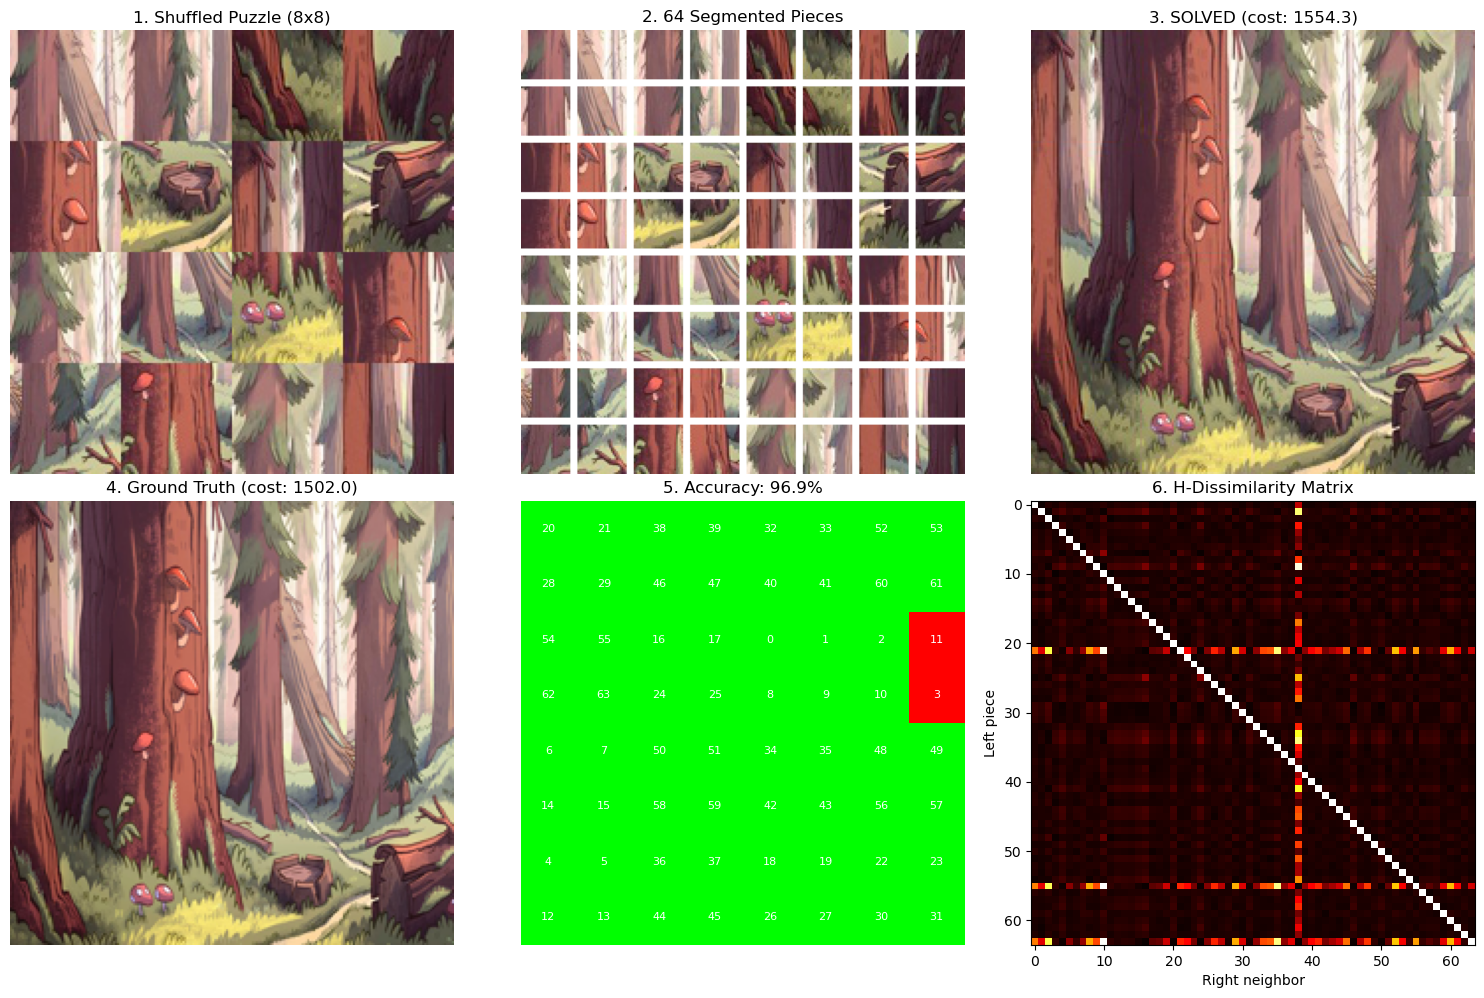


Puzzle 4 (4x4): 96.9% accuracy


In [29]:
def visualize_pipeline_single(idx = 8,grid_size=8):         
    folder_map = {2: 'puzzle_2x2', 4: 'puzzle_4x4', 8: 'puzzle_8x8'}
    puzzle_path = f'../data/raw/GravityFalls/{folder_map[grid_size]}/{idx}.jpg'
    correct_path = f'../data/raw/GravityFalls/correct/{idx}.png'
            

    accuracy = visualize_pipeline(puzzle_path, correct_path, 8,)
    
    print(f"\nPuzzle {idx} ({grid_size}x{grid_size}): {accuracy:.1f}% accuracy")


visualize_pipeline_single(4,4)

In [19]:
DATA_DIR ="../data"
RAW_DIR = DATA_DIR + "/raw/GravityFalls"
SOLUTION_DIR = DATA_DIR + "/solutions"
folder_map = {2: 'puzzle_2x2', 4: 'puzzle_4x4', 8: 'puzzle_8x8'}

import csv

def run_full_test(grid_size, show_failed=False):
    """Run tests on all puzzles of a given size."""
    puzzle_dir = f'{RAW_DIR}/{folder_map[grid_size]}'
    correct_dir = f'{RAW_DIR}/correct'
    
    # Create output directory for solutions
    output_dir = f'{SOLUTION_DIR}/puzzle{grid_size}x{grid_size}'
    os.makedirs(output_dir, exist_ok=True)
    
    puzzle_files = sorted([f for f in os.listdir(puzzle_dir) if f.endswith(('.png', '.jpg'))])
    
    results = []
    for pf in puzzle_files:
        puzzle_path = os.path.join(puzzle_dir, pf)
        base_name = os.path.splitext(pf)[0]
        correct_path = os.path.join(correct_dir, base_name + '.png')
        
        puzzle_image = np.array(Image.open(puzzle_path).convert('RGB'))
        correct_image = np.array(Image.open(correct_path).convert('RGB'))
        
        correct_arr = get_correct_mapping(puzzle_image, correct_image, grid_size)
        
        result = solve_puzzle(puzzle_image, grid_size)
        arr = result['arr']
        
        # Reassemble and save the solved image
        pieces = segment_image(puzzle_image, grid_size)
        solved_image = reassemble_image(pieces, arr, grid_size)
        output_path = os.path.join(output_dir, f'{base_name}.png')
        Image.fromarray(solved_image).save(output_path)
        
        accuracy = (arr == correct_arr).sum() / arr.size * 100
        results.append({
            'file': base_name,
            'accuracy': accuracy,
            'method': result.get('method', 'unknown'),
            'cost': result['cost'],
            'output_path': output_path
        })
    
    # Save results to CSV
    csv_path = os.path.join(output_dir, f'results_{grid_size}x{grid_size}.csv')
    with open(csv_path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['file', 'accuracy', 'method', 'cost',  'output_path'])
        writer.writeheader()
        writer.writerows(results)
    
    # Summary
    perfect = sum(1 for r in results if r['accuracy'] == 100.0)
    failed = sum(1 for r in results if r['accuracy'] == 0.0)
    mean_acc = np.mean([r['accuracy'] for r in results])
    
    print(f"\n{'='*50}")
    print(f"{grid_size}x{grid_size} Puzzle Results")
    print(f"{'='*50}")
    print(f"Perfect (100%): {perfect}/110 ({perfect/110*100:.1f}%)")
    print(f"Failed (0%):    {failed}/110 ({failed/110*100:.1f}%)")
    print(f"Mean Accuracy:  {mean_acc:.1f}%")
    print(f"Images saved to: {output_dir}")
    print(f"CSV saved to: {csv_path}")
    print(f"{'='*50}")
    
    if show_failed:
        print("\nFailed puzzles:")
        for r in results:
            if r['accuracy'] == 0.0:
                print(f"  {r['file']}: method={r['method']}, cost={r['cost']:.1f}")
    
    return results


In [ ]:
run_full_test(8)